# 전이 학습(Transfer Learning)

박성호 교수님 자료(https://www.youtube.com/NeoWizard)

* https://youtu.be/r4nQgQkdOqM
* https://youtu.be/fAgTGrcKE2E
* https://github.com/neowizard2018/neowizard/tree/master/TensorFlow2
* https://github.com/neowizard2018/neowizard/blob/master/TensorFlow2/TF_LEC_26_Example_Categorical.ipynb

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# 파일 다운로드

!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-10-16 05:51:16--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   265MB/s    in 0.2s    

2022-10-16 05:51:16 (265 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
import os
import shutil

if os.path.exists('/content/cats_and_dogs_filtered/'):    # 작업 디렉토리는 cats_and_dogs_filtered
    
    shutil.rmtree('/content/cats_and_dogs_filtered/')
    print('/content/cats_and_dogs_filtered/  is removed !!!')

In [4]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile('/content/cats_and_dogs_filtered.zip', 'r') as target_file:

    target_file.extractall('/content/cats_and_dogs_filtered/') 

In [5]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

In [6]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH,IMG_HEIGHT,3))

base_model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [7]:
model = Sequential()

model.add(base_model)

model.add(GlobalAveragePooling2D())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                32784     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 20,894,298
Trainable params: 20,839,770
Non-trainable params: 54,528
_______________________________________

In [8]:
# ImageDataGenerator 이용하여 데이터 불러옴

train_data_gen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=10, width_shift_range=0.1, 
                                    height_shift_range=0.1, shear_range=0.1, zoom_range=0.1)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [9]:
train_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/train'

test_dir = '/content/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

class_mode='categorical' 이므로 정답은 one-hot encoding 됨.

In [10]:
train_data = train_data_gen.flow_from_directory(train_dir, batch_size=32, 
                                                color_mode='rgb', shuffle=True, class_mode='categorical',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))


test_data = test_data_gen.flow_from_directory(test_dir, batch_size=32, 
                                              color_mode='rgb', shuffle=True, class_mode='categorical',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [11]:
# 정답 확인

print(train_data.class_indices.items())
print(test_data.class_indices.items())

print(len(train_data.classes))
print(len(test_data.classes))

print(train_data.num_classes)
print(test_data.num_classes)

dict_items([('cats', 0), ('dogs', 1)])
dict_items([('cats', 0), ('dogs', 1)])
2000
1000
2
2


In [12]:
# 모델 컴파일

model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(2e-5), metrics=['accuracy'])

In [13]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

save_file_name = './cats_and_dogs_filtered_Xception_Colab.h5'

checkpoint = ModelCheckpoint(save_file_name,       
                             monitor='val_loss',   
                             verbose=1,            
                             save_best_only=True,  
                             mode='auto'           
                            )

earlystopping = EarlyStopping(monitor='val_loss',  
                              patience=5,          
                             )


start_time = datetime.now()

hist = model.fit(train_data, epochs=30, 
                 validation_data=test_data,
                 callbacks=[checkpoint, earlystopping])

end_time = datetime.now()

print('elapsed time = ', end_time-start_time)

Epoch 1/30
63/63 [==============================] - ETA: 0s - loss: 0.4397 - accuracy: 0.8400
Epoch 1: val_loss improved from inf to 0.10939, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 62s 725ms/step - loss: 0.4397 - accuracy: 0.8400 - val_loss: 0.1094 - val_accuracy: 0.9770
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.9660
Epoch 2: val_loss improved from 0.10939 to 0.05206, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 43s 673ms/step - loss: 0.1742 - accuracy: 0.9660 - val_loss: 0.0521 - val_accuracy: 0.9790
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9765
Epoch 3: val_loss improved from 0.05206 to 0.04236, saving model to ./cats_and_dogs_filtered_Xception_Colab.h5
63/63 [==============================] - 43s 683ms/step - loss: 0.1018 - accuracy: 0.9765 - val_loss: 0.0424 - val_accuracy: 

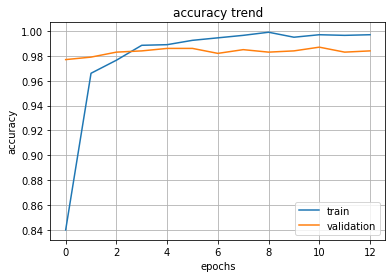

In [14]:
import matplotlib.pyplot as plt

plt.title('accuracy trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.legend(loc='best')
plt.show()

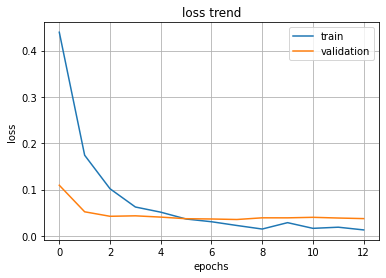

In [15]:
import matplotlib.pyplot as plt

plt.title('loss trend')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.legend(loc='best')
plt.show()

In [16]:
import os
import shutil

if os.path.exists('/content/test_image_dir/'):    
    
    shutil.rmtree('/content/test_image_dir/')
    print('/content/test_image_dir/  is removed !!!')

In [17]:
# 압축파일 풀기

import zipfile

with zipfile.ZipFile('/content/test_image_dir.zip', 'r') as target_file:

    target_file.extractall('/content/test_image_dir/') 

In [18]:
import cv2
import glob

test_img_list = []

test_img_name_list = glob.glob('test_image_dir/test_image_dir/*')

for i in range(len(test_img_name_list)):

    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))

    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    dst_img = dst_img / 255.0

    test_img_list.append(dst_img)

print(test_img_name_list)
print(len(test_img_list))

['test_image_dir/test_image_dir/cat-2536662__480.jpg', 'test_image_dir/test_image_dir/maltese-1123016__480.jpg']
2


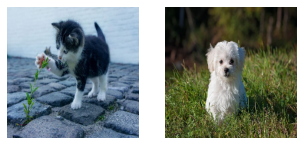

In [19]:
plt.figure(figsize=(8,6))

for i in range(len(test_img_list)):

    plt.subplot(2, 3, i+1)
    plt.axis('off')
    plt.imshow(test_img_list[i])

plt.show()

In [20]:
for i in range(len(test_img_list)):

    print(test_img_list[i].shape)

(224, 224, 3)
(224, 224, 3)


In [21]:
# predict 수행하기 위해 batch 차원 추가
import numpy as np

print(np.array(test_img_list).shape)

(2, 224, 224, 3)


In [22]:
# predict 실행

class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

pred = model.predict(np.array(test_img_list))

print(pred.shape)
print(pred)

1/1 [==============================] - 1s 1s/step
(2, 2)
[[9.3686265e-01 6.3137382e-02]
 [8.9083333e-04 9.9910909e-01]]


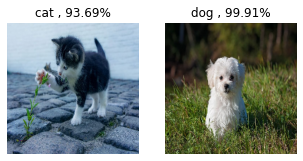

In [23]:
class_name = [ 'cat', 'dog' ]  # ImageDataGenerator 에서 cat=0, dog=1

plt.figure(figsize=(8,6))

for i in range(len(pred)):

    plt.subplot(2, 3, i+1)
    prediction = str(class_name[np.argmax(pred[i])])
    probility = '{0:0.2f}'.format(100*max(pred[i]))
    title_str = prediction + ' , ' + probility + '%'
    plt.axis('off')
    plt.title(title_str)
    plt.imshow(test_img_list[i])

plt.show()